3. Для всех инструментов, входящих в портфель, реализовать оценку их справедливой стоимости в зависимости от риск-факторов. Критически обсудить выбор модели. Обязательно проверить точность модели.

В качестве модели будем строить [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares#:~:text=Further%20reading-,Linear%20model,-%5Bedit%5D).

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
risks = pd.read_csv('risks.csv', skiprows = [1])
risks.set_index(risks.columns[0], inplace=True)
risks.rename_axis(None, inplace=True)

# Добавляем константу
risks = sm.add_constant(risks)

C:\Users\wchhi\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [3]:
risks.head()

,const,RTSI_RUB,RTSI_USD,IMOEX,CNY,USD,ZeroCoupon
2016-01-06,1.0,-0.011840,-0.021097,-0.003170,0.006311,0.019696,-0.0004
2016-01-11,1.0,-0.031959,-0.051152,-0.037762,0.042947,0.019409,-0.0001
2016-01-12,1.0,0.002648,-0.005450,0.004612,0.011449,0.011206,-0.0009
2016-01-13,1.0,-0.000440,-0.002402,-0.003266,-0.007223,-0.005035,0.0174
2016-01-14,1.0,0.000272,-0.000951,-0.002380,-0.010295,-0.008164,-0.0007


In [4]:
idx = pd.date_range("2016-01-05", "2021-12-30")

#### Облигации

В облигации будет оцениваться доходность по средневзвешенной цене, % годовых

In [5]:
bonds = [
    "SU26207RMFS9",
    "SU26209RMFS5",
    "SU26211RMFS1",
    "SU26212RMFS9",
    "SU26215RMFS2"
]

bonds_y = []

In [6]:
for i, bond in enumerate(bonds):
    if i in [0, 3, 2, 4]:
        bond_i = pd.read_csv("..\\data\\bonds\\history\\" + bond + ".csv", index_col = 'TRADEDATE',
                            skiprows = [1])['YIELDATWAP']
    else:
        bond_i = pd.read_csv("..\\data\\bonds\\history\\" + bond + ".csv", index_col = 'TRADEDATE')['YIELDATWAP']
        
    bond_i = bond_i.pct_change().dropna()
    bond_i.index = pd.to_datetime(bond_i.index)
    bond_i.reindex(idx).interpolate(inplace=True)
    
    bonds_y.append(bond_i)

Для каждого из бондов строим модель, смотрим результат:

In [7]:
reses_bonds, preds_bonds = [], []

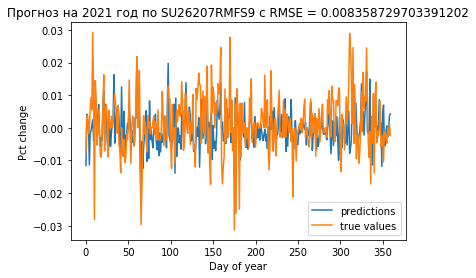

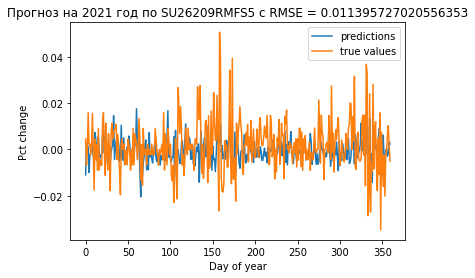

C:\Users\wchhi\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1666: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


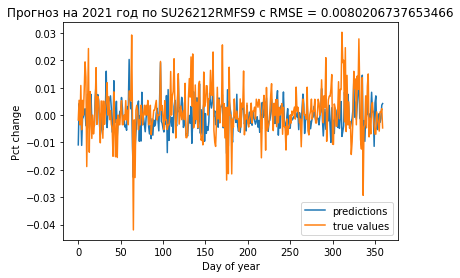

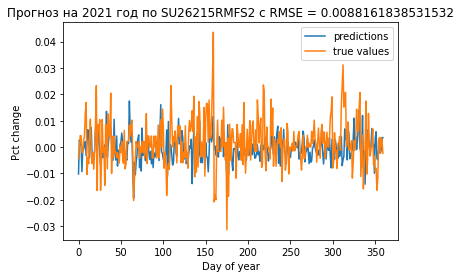

In [8]:
for i, _ in enumerate(bonds_y):
    # Для саммари
    model = sm.OLS(bonds_y[i].values, risks)
    res = model.fit()
    reses_bonds.append(res.summary())

    # Для валидации
    model_val = sm.OLS(bonds_y[i].values[:-360], risks.to_numpy()[:-360])
    model_val = model_val.fit()
    
    ypred = model_val.predict(risks.to_numpy()[-360:])
    preds_bonds.append(ypred)
    
    try:
        error_i = mean_squared_error(bonds_y[i].values[-360:], ypred, squared=False)
    except:
        pass
    else:
        plt.figure()
        plt.plot(preds_bonds[-1], label = 'predictions')
        plt.plot(bonds_y[i].values[-360:], label = 'true values')
        plt.title('Прогноз на 2021 год по {} с RMSE = {}'.format(bonds[i], error_i))
        plt.xlabel('Day of year')
        plt.ylabel('Pct change')
        plt.legend()
        plt.show()

$R^2 \in [0.225;0.380]$

In [9]:
reses_bonds[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     154.0
Date:                Mon, 25 Apr 2022   Prob (F-statistic):          1.39e-152
Time:                        07:19:09   Log-Likelihood:                 5176.9
No. Observations:                1513   AIC:                        -1.034e+04
Df Residuals:                    1506   BIC:                        -1.030e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.498      0.619      -0.000       0.001
RTSI_RUB       0.5106      0.035     14.640      0.000       0.442       0.579
RTSI_USD      -0.6176      0.045    -13.765      0.000      -0.706      -0.530
IMOEX         -0.0952      0.061     -1.566      0.117      -0.215       0.024
CNY            0.0461      0.053      0.862      0.389      -0.059       0.151
USD           -0.0117      0.061     -0.192      0.847      -0.131       0.108
ZeroCoupon    -0.0100      0.045     -0.225      0.822      -0.097       0.077
==============================================================================
Omnibus:                      303.951   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7655.361
Skew:                           0.235   Prob(JB):                         0.00
Kurtosis:                      14.010   Cond. No.                         406.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Акции и валюта**

Строим модель динамики для каждой акции, в качестве **справедливой стоимости** выберем цену [weighted average price](https://www.foxbusiness.com/markets/how-to-calculate-weighted-average-price-per-share#:~:text=In%20order%20to%20calculate%20your%20weighted%20average%20price%20per%20share%2C%20simply%20multiply%20each%20purchase%20price%20by%20the%20amount%20of%20shares%20purchased%20at%20that%20price%2C%20add%20them%20together%2C%20and%20then%20divide%20by%20the%20total%20number%20of%20shares.), так как для долговременного прогноза кажется наименее пере- или недооценённым использовать взвешенную стоимость акции по всем торгам за прошедшее время.

In [10]:
stocks = [
    "ALRS",
    "GAZP",
    "GMKN",
    "LKOH",
    "MGNT",
    "NLMK",
    "NVTK",
    "PLZL",
    "POLY",
    "ROSN"
]

stocks_y = []

In [11]:
for stock in stocks:
    stock_i = pd.read_csv("..\\data\\stocks\\history\\" + stock + ".csv", index_col = 'TRADEDATE', 
                          skiprows=[1])['WAPRICE']
    
    stock_i = stock_i.pct_change().dropna()
    stock_i.index = pd.to_datetime(stock_i.index)
    stock_i.reindex(idx).interpolate(inplace=True)
    
    stocks_y.append(stock_i)

Валюта

In [12]:
currs = [
    "CNYRUB_TOM",
    "USD000UTSTOM",
    "EUR_RUB__TOM"
]

currs_y = []

In [13]:
for curr in currs:
    curr_i = pd.read_csv("..\\data\\currencies\\history\\" + curr + ".csv", index_col = 'TRADEDATE', 
                          skiprows=[1])['WAPRICE']
    
    curr_i = curr_i.pct_change().dropna()
    curr_i.index = pd.to_datetime(curr_i.index)
    curr_i.reindex(idx).interpolate(inplace=True)
    
    currs_y.append(curr_i)

Расчёт результатов для акций и валют

In [14]:
reses_stocks, preds_stocks = [], []

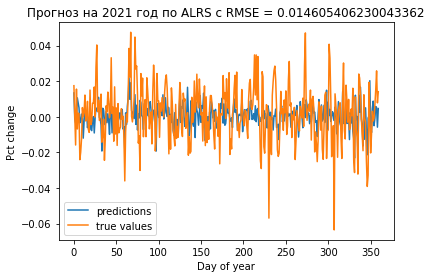

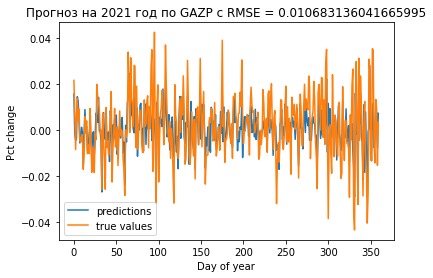

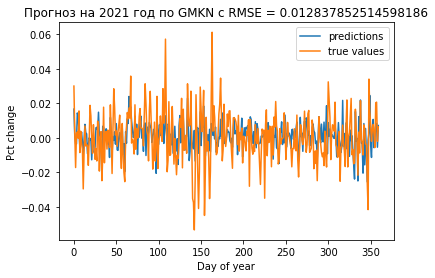

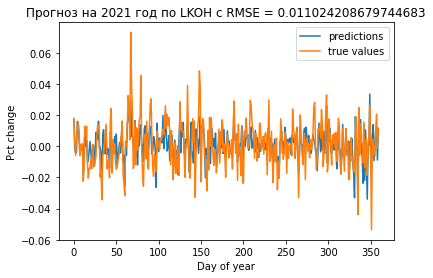

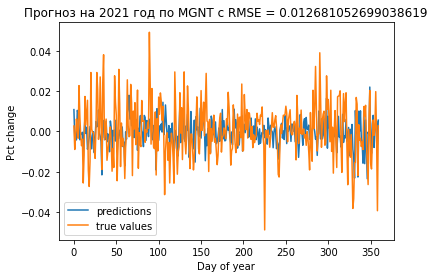

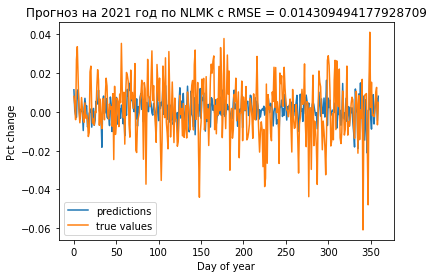

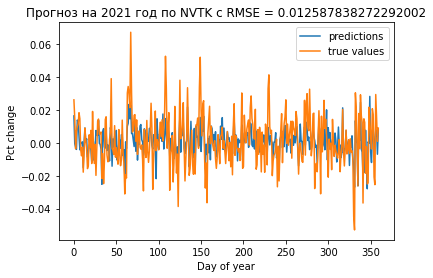

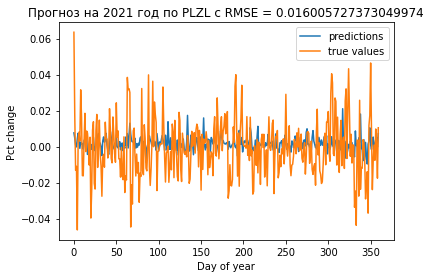

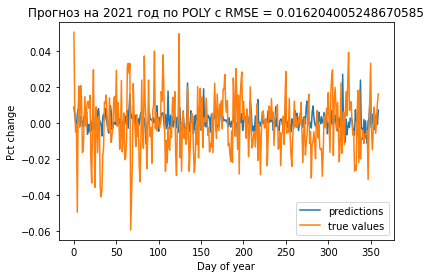

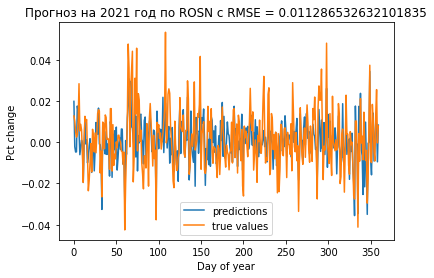

In [15]:
for i, _ in enumerate(stocks_y):
    # Для саммари
    model = sm.OLS(stocks_y[i].values, risks)
    res = model.fit()
    reses_stocks.append(res.summary())

    # Для валидации
    model_val = sm.OLS(stocks_y[i].values[:-360], risks.to_numpy()[:-360])
    model_val = model_val.fit()
    
    ypred = model_val.predict(risks.to_numpy()[-360:])
    preds_stocks.append(ypred)
    
    try:
        error_i = mean_squared_error(stocks_y[i].values[-360:], ypred, squared=False)
    except:
        pass
    else:
        plt.figure()
        plt.plot(preds_stocks[-1], label = 'predictions')
        plt.plot(stocks_y[i].values[-360:], label = 'true values')
        plt.title('Прогноз на 2021 год по {} с RMSE = {}'.format(stocks[i], error_i))
        plt.xlabel('Day of year')
        plt.ylabel('Pct change')
        plt.legend()
        plt.show()

In [16]:
reses_stocks

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.183
 Model:                            OLS   Adj. R-squared:                  0.180
 Method:                 Least Squares   F-statistic:                     56.15
 Date:                Mon, 25 Apr 2022   Prob (F-statistic):           9.09e-63
 Time:                        07:19:30   Log-Likelihood:                 4293.8
 No. Observations:                1513   AIC:                            -8574.
 Df Residuals:                    1506   BIC:                            -8536.
 Df Model:                           6                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

$R^2 \in [0.037;0.469]$

In [17]:
reses_currs, preds_curs = [], []

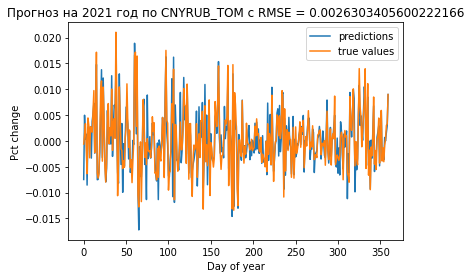

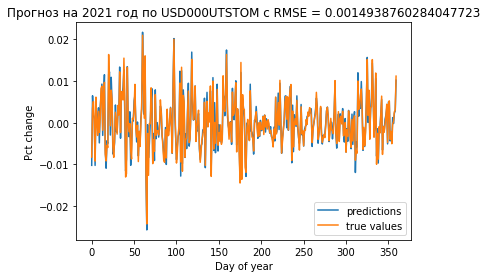

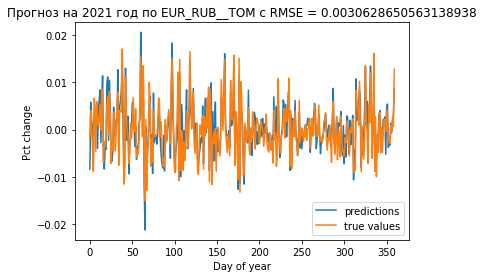

In [18]:
for i, _ in enumerate(currs_y):
    model = sm.OLS(currs_y[i].values, risks)
    res = model.fit()
    reses_currs.append(res.summary())
    
    
    # Для валидации
    model_val = sm.OLS(currs_y[i].values[:-360], risks.to_numpy()[:-360])
    model_val = model_val.fit()
    
    ypred = model_val.predict(risks.to_numpy()[-360:])
    preds_curs.append(ypred)
    
    try:
        error_i = mean_squared_error(currs_y[i].values[-360:], ypred, squared=False)
    except:
        pass
    else:
        plt.figure()
        plt.plot(preds_curs[-1], label = 'predictions')
        plt.plot(currs_y[i].values[-360:], label = 'true values')
        plt.title('Прогноз на 2021 год по {} с RMSE = {}'.format(currs[i], error_i))
        plt.xlabel('Day of year')
        plt.ylabel('Pct change')
        plt.legend()
        plt.show()

$R^2 \in [0.740;0.951]$

In [19]:
reses_currs

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.799
 Model:                            OLS   Adj. R-squared:                  0.798
 Method:                 Least Squares   F-statistic:                     998.0
 Date:                Mon, 25 Apr 2022   Prob (F-statistic):               0.00
 Time:                        07:19:42   Log-Likelihood:                 6406.7
 No. Observations:                1513   AIC:                        -1.280e+04
 Df Residuals:                    1506   BIC:                        -1.276e+04
 Df Model:                           6                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------